# ♈ Course Project: Hands on Nerual Networks

# **姓名（学号）：袁泽（250010098） 梁益菲（250010024） 邓星宇（250010109）**

### **汇报时间：2025.12.09，（1）每队讲解并演示代码；（2）各队对比训练时间和性能。**

This notebook is the course project for the course "Optimization Theory and Algorithms" in SLAI (Instructor: Lin Gao)

## 从零实现一个多层神经网络训练过程

**主要特性：**

以下程序实现内容包括：

1. 加载数据集（从本地 gzip 文件或在线下载）。

2. 构造输入层→多个隐藏层→输出层（softmax）的多层神经网络。

3. 前向传播（输出层激活函数用Softmax，其他层用Sigmoid）。

4. 反向传播计算梯度（Loss函数用交叉熵）。

5. 训练模型参数（Mini-batch，优化器/优化算法可选：SGD，Momentum，Nesterov，Adagrad，Adadelta，Adam，其他）。

5. 对比不同优化器下的Loss和Accuracy曲线。

**附加说明：**

1. 不使用 TensorFlow / PyTorch，全程只依赖 numpy。

2. 前向、反向、梯度计算、参数更新过程完全手写：

3. 前向过程缓存 Z（线性输出）、A（激活函数输出），供反向传播过程使用；

4. 反向传播时直接调用缓存，简化梯度计算过程。

**可调整参数：**

1. 隐藏层结构、学习率、各类优化器的超参数；

2. 训练集大小、测试集大小，Batch_size、epoc。


### **Part I: Load Data and Pre-Process**

In [15]:
import numpy as np
import gzip
import os
import urllib.request
import matplotlib.pyplot as plt

# -------------------------------
# 一、MNIST 数据加载（可替换成其他数据）
# -------------------------------
def download_file(url, filename):
    print(f"Downloading {filename} ...")
    urllib.request.urlretrieve(url, filename)

def load_mnist(path="./", kind='train'):
    """
    从 Google/OpenML 镜像加载MNIST数据。
    kind: 'train' or 't10k'
    """
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    # 确保路径存在
    os.makedirs(path, exist_ok=True)

    # 替换官方已失效网址
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    if not os.path.exists(labels_path):
        download_file(base_url + f'{kind}-labels-idx1-ubyte.gz', labels_path)
    if not os.path.exists(images_path):
        download_file(base_url + f'{kind}-images-idx3-ubyte.gz', images_path)

    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

    images = images.astype(np.float32) / 255.0
    return images, labels


In [16]:
# Google Colab 特定代码（如果在本地运行可以注释掉）
# from google.colab import drive
# drive.mount('/content/drive')

### **Part II: Define Basic Functions**

In [17]:
# -------------------------------
# 二、基础函数（如激活函数及导数）
# -------------------------------

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, num_classes):
    m = y.shape[0]
    res = np.zeros((m, num_classes))
    res[np.arange(m), y] = 1
    return res

### **Part III: Define Neural Network Class**

In [ ]:
# -------------------------------
# 三、多层神经网络类
# -------------------------------

class NeuralNet:
    # ----------------------
    # 初始化函数
    # 输入：网络结构、优化器、学习率、超参数等
    # ----------------------
    def __init__(self, layers, optimizer='sgd', lr=0.01, beta=0.9, beta1=0.9, beta2=0.999, rho=0.95, eps=1e-8):
        """
        layers: 网络结构，例如 [784, 128, 64, 10]
        optimizer: 'sgd', 'momentum', 'nesterov', 'adagrad', 'adadelta', 'adam'，可增加其他优化器
        lr: 学习率
        beta: 动量参数 (用于 SGD with momentum / Nesterov)
        beta1, beta2: Adam 参数
        rho: Adadelta 参数
        eps: 防止除零
        """
        self.layers = layers
        self.num_layers = len(layers) - 1
        self.optimizer = optimizer

        # 初始超参数
        self.lr = lr
        self.beta = beta  # momentum
        self.beta1 = beta1  # Adam
        self.beta2 = beta2  # Adam
        self.rho = rho  # Adadelta
        self.eps = eps

        # 初始化权重W和b（使用Xavier初始化以提高训练速度）
        self.W = []
        self.b = []
        for i in range(self.num_layers):
            # Xavier初始化
            limit = np.sqrt(6.0 / (layers[i] + layers[i+1]))
            w = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
            b = np.zeros((1, layers[i+1]))
            self.W.append(w)
            self.b.append(b)

        # 初始化优化器缓存
        self.v_W = [np.zeros_like(w) for w in self.W]  # momentum velocity
        self.v_b = [np.zeros_like(b) for b in self.b]

        # Adagrad缓存
        self.cache_W_adagrad = [np.zeros_like(w) for w in self.W]
        self.cache_b_adagrad = [np.zeros_like(b) for b in self.b]

        # Adadelta缓存
        self.cache_W_adadelta = [np.zeros_like(w) for w in self.W]
        self.cache_b_adadelta = [np.zeros_like(b) for b in self.b]
        self.delta_W_adadelta = [np.zeros_like(w) for w in self.W]
        self.delta_b_adadelta = [np.zeros_like(b) for b in self.b]

        # Adam缓存
        self.m_W = [np.zeros_like(w) for w in self.W]  # 一阶矩
        self.m_b = [np.zeros_like(b) for b in self.b]
        self.v_W_adam = [np.zeros_like(w) for w in self.W]  # 二阶矩
        self.v_b_adam = [np.zeros_like(b) for b in self.b]
        self.t = 0  # Adam时间步
        
        # Muon缓存
        self.muon_m_W = [np.zeros_like(w) for w in self.W]
        self.muon_m_b = [np.zeros_like(b) for b in self.b]

        # 前向传播缓存
        self.Z_cache = []  # 线性输出
        self.A_cache = []  # 激活输出




    # ----------------------
    # Compute Loss
    # 输入：神经网络预测的输出，数据真实Label
    # 输出：Cross-entropy Loss（交叉熵）
    # ----------------------
    def compute_loss(self, y_pred, y_true):
        """
        y_pred: 预测输出 (batch_size, num_classes)
        y_true: 真实标签 one-hot编码 (batch_size, num_classes)
        """
        m = y_pred.shape[0]
        # 避免log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    # ----------------------
    # Predict
    # 输入：数据
    # 输出：神经网络预测的结果
    # ----------------------
    def predict(self, X):
        """
        X: 输入数据 (batch_size, input_size)
        返回: 预测类别 (batch_size,)
        """
        A = X
        # 前向传播（不保存缓存）
        for i in range(self.num_layers - 1):
            Z = np.dot(A, self.W[i]) + self.b[i]
            A = sigmoid(Z)

        # 输出层
        Z = np.dot(A, self.W[-1]) + self.b[-1]
        A = softmax(Z)

        return np.argmax(A, axis=1)

    # ----------------------
    # Forward（前向过程）
    # 输入：数据
    # 输出：每一层的中间计算结果，保存为缓存（用于Backward过程）
    # ----------------------
    def forward(self, X):
        """
        X: 输入数据 (batch_size, input_size)
        返回: 输出层激活值
        """
        # 清空缓存
        self.Z_cache = []
        self.A_cache = []

        A = X
        self.A_cache.append(A)  # 输入层

        # 隐藏层（使用Sigmoid）
        for i in range(self.num_layers - 1):
            Z = np.dot(A, self.W[i]) + self.b[i]
            self.Z_cache.append(Z)
            A = sigmoid(Z)
            self.A_cache.append(A)

        # 输出层（使用Softmax）
        Z = np.dot(A, self.W[-1]) + self.b[-1]
        self.Z_cache.append(Z)
        A = softmax(Z)
        self.A_cache.append(A)

        return A

    # ----------------------
    # Backward（反向传播过程）
    # 输入：Forward过程缓存的中间计算结果，数据真实Label
    # 输出：利用Chain Rule，反向传播计算每个参数的梯度值
    # ----------------------
    def backward(self, y_true):
        """
        y_true: 真实标签 one-hot编码 (batch_size, num_classes)
        返回: dW, db (梯度列表)
        """
        m = y_true.shape[0]
        dW = []
        db = []

        # 输出层梯度（交叉熵 + Softmax）
        dA = self.A_cache[-1] - y_true  # (batch_size, num_classes)
        dW_output = np.dot(self.A_cache[-2].T, dA) / m
        db_output = np.sum(dA, axis=0, keepdims=True) / m
        dW.append(dW_output)
        db.append(db_output)

        # 反向传播到隐藏层
        dA_next = np.dot(dA, self.W[-1].T)

        # 从倒数第二层到第一层
        for i in range(self.num_layers - 2, -1, -1):
            # 计算当前层的梯度
            dZ = dA_next * sigmoid_derivative(self.Z_cache[i])
            dW_i = np.dot(self.A_cache[i].T, dZ) / m
            db_i = np.sum(dZ, axis=0, keepdims=True) / m

            dW.insert(0, dW_i)
            db.insert(0, db_i)

            # 计算前一层梯度
            if i > 0:
                dA_next = np.dot(dZ, self.W[i].T)

        return dW, db

    # ----------------------
    # Helper for Muon
    # ----------------------
    @staticmethod
    def _newton_schulz(G, steps=5, eps=1e-7):
        """
        Newton-Schulz iteration to compute the sign of a matrix
        """
        # Ensure G is 2D. If 1D (like bias), reshape to (1, n) or handled separately?
        # In our case, W is 2D. b is (1, n) which is 2D.
        # But if b is (n,), we need reshape. Our init says b is (1, layers[i+1]).
        
        # Scale G to ensure spectral norm < 1 (approx)
        # Using Frobenius norm as a proxy or just dividing by a safe constant?
        # Original implementation uses: X = G / (G.norm() + eps)
        
        # Frobenius norm
        norm = np.linalg.norm(G, ord='fro')
        X = G / (norm + eps)
        
        # Iteration: X_{k+1} = 0.5 * X_k * (3I - X_k^T * X_k)
        # Note: Transpose logic depends on shape.
        # If G is (rows, cols), X^T * X is (cols, cols) if rows > cols?
        # The Newton-Schulz for sign(A) usually works for square matrices or uses SVD logic for rectangular.
        # "Muon is an optimizer for hidden layers... optimizing 2D tensors"
        # The update is: G <- NewtonSchulz(G)
        # For rectangular A (m x n), we want U V^T where A = U S V^T.
        # The iteration is: X_{k+1} = X_k * (3I - X_k^T X_k) * 0.5   if m >= n
        #                   X_{k+1} = 0.5 * (3I - X_k X_k^T) * X_k   if m < n
        
        m, n = X.shape
        if m >= n:
            for _ in range(steps):
                # X_k^T * X_k -> (n, n)
                A = np.dot(X.T, X)
                # 3I - A
                B = 3 * np.eye(n) - A
                # X * B * 0.5
                X = 0.5 * np.dot(X, B)
        else:
            for _ in range(steps):
                # X_k * X_k^T -> (m, m)
                A = np.dot(X, X.T)
                # 3I - A
                B = 3 * np.eye(m) - A
                # B * X * 0.5
                X = 0.5 * np.dot(B, X)
                
        return X



    # ----------------------
    # Update Weights (using different algorithms/optimizers)
    # 输入：Backword过程得到的每个参数的梯度值
    # 执行：根据不同优化器（optimizers）规则，更新模型参数
    # 输出：更新之后的模型参数
    # ----------------------
    def update(self, dW, db):
        """
        dW, db: 梯度列表
        """
        opt = self.optimizer

        if opt == "sgd":
            # 标准SGD
            for i in range(self.num_layers):
                self.W[i] -= self.lr * dW[i]
                self.b[i] -= self.lr * db[i]

        elif opt == "momentum":
            # Momentum优化器
            for i in range(self.num_layers):
                self.v_W[i] = self.beta * self.v_W[i] + self.lr * dW[i]
                self.v_b[i] = self.beta * self.v_b[i] + self.lr * db[i]
                self.W[i] -= self.v_W[i]
                self.b[i] -= self.v_b[i]

        elif opt == "nesterov":
            # Nesterov加速梯度 (NAG) - 标准近似实现
            # 公式: 
            # v_{t+1} = beta * v_t + lr * dW
            # W_{t+1} = W_t - (beta * v_{t+1} + lr * dW)
            for i in range(self.num_layers):
                # 1. 更新 velocity (累积动量)
                self.v_W[i] *= self.beta
                self.v_W[i] += self.lr * dW[i]
                
                self.v_b[i] *= self.beta
                self.v_b[i] += self.lr * db[i]
                
                # 2. Nesterov 更新 (使用新计算的 velocity 进行校正)
                # 这一步体现了 "lookahead" 的效果
                self.W[i] -= self.beta * self.v_W[i] + self.lr * dW[i]
                self.b[i] -= self.beta * self.v_b[i] + self.lr * db[i]

        elif opt == "adagrad":
            # Adagrad优化器
            for i in range(self.num_layers):
                self.cache_W_adagrad[i] += dW[i] ** 2
                self.cache_b_adagrad[i] += db[i] ** 2

                self.W[i] -= self.lr * dW[i] / (np.sqrt(self.cache_W_adagrad[i]) + self.eps)
                self.b[i] -= self.lr * db[i] / (np.sqrt(self.cache_b_adagrad[i]) + self.eps)

        elif opt == "adadelta":
            # Adadelta优化器
            for i in range(self.num_layers):
                # 更新累积梯度平方
                self.cache_W_adadelta[i] = self.rho * self.cache_W_adadelta[i] + (1 - self.rho) * (dW[i] ** 2)
                self.cache_b_adadelta[i] = self.rho * self.cache_b_adadelta[i] + (1 - self.rho) * (db[i] ** 2)

                # 计算参数更新
                delta_W = -np.sqrt(self.delta_W_adadelta[i] + self.eps) / np.sqrt(self.cache_W_adadelta[i] + self.eps) * dW[i]
                delta_b = -np.sqrt(self.delta_b_adadelta[i] + self.eps) / np.sqrt(self.cache_b_adadelta[i] + self.eps) * db[i]

                # 更新参数
                self.W[i] += delta_W
                self.b[i] += delta_b

                # 更新累积更新平方
                self.delta_W_adadelta[i] = self.rho * self.delta_W_adadelta[i] + (1 - self.rho) * (delta_W ** 2)
                self.delta_b_adadelta[i] = self.rho * self.delta_b_adadelta[i] + (1 - self.rho) * (delta_b ** 2)

        elif opt == "adam":
            # Adam优化器
            self.t += 1
            for i in range(self.num_layers):
                # 更新一阶矩估计
                self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * dW[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]

                # 更新二阶矩估计
                self.v_W_adam[i] = self.beta2 * self.v_W_adam[i] + (1 - self.beta2) * (dW[i] ** 2)
                self.v_b_adam[i] = self.beta2 * self.v_b_adam[i] + (1 - self.beta2) * (db[i] ** 2)

                # 偏差修正
                m_W_corrected = self.m_W[i] / (1 - self.beta1 ** self.t)
                m_b_corrected = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_W_corrected = self.v_W_adam[i] / (1 - self.beta2 ** self.t)
                v_b_corrected = self.v_b_adam[i] / (1 - self.beta2 ** self.t)

                # 更新参数
                self.W[i] -= self.lr * m_W_corrected / (np.sqrt(v_W_corrected) + self.eps)
                self.b[i] -= self.lr * m_b_corrected / (np.sqrt(v_b_corrected) + self.eps)

        elif opt == "muon":
            # Muon Optimizer
            # Typically Muon is used for >= 2D parameters (Weights)
            
            for i in range(self.num_layers):
                # 1. 更新momentum
                # self.muon_m_W[i] = self.beta * self.muon_m_W[i] + dW[i]
                # Keller's repo: buf.mul_(momentum).add_(grad) -> buf = m * buf + g
                self.muon_m_W[i] *= self.beta
                self.muon_m_W[i] += dW[i]
                
                self.muon_m_b[i] *= self.beta
                self.muon_m_b[i] += db[i]
                
                # 2. 用 Newton-Schulz 来正交化 momentum of Weights
                # Only for W (2D)
                update_W = self._newton_schulz(self.muon_m_W[i])
                
                # 3. Update Weights
                # W -= lr * update_W
                self.W[i] -= self.lr * update_W
                
                # 4. Update Biases
                # For biases, 我们用momentum来更新
                self.b[i] -= self.lr * self.muon_m_b[i]


### **Part IV: Model Training**

In [19]:
# -------------------------------
# 四、Train过程
#   输入参数：模型、训练数据集+标签、测试数据集+标签，epoch数量，batch_size等
#   输出结果：损失曲线、训练集精度曲线、测试集精度曲线
# -------------------------------

def train(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    """
    训练模型
    """
    # 转换为one-hot编码
    y_train_onehot = one_hot(y_train, model.layers[-1])
    y_test_onehot = one_hot(y_test, model.layers[-1])

    losses_list = []
    train_acc_list = []
    test_acc_list = []

    m_train = X_train.shape[0]
    num_batches = m_train // batch_size

    for epoch in range(epochs):
        # 打乱数据
        indices = np.random.permutation(m_train)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_onehot[indices]

        epoch_losses = []

        # Mini-batch训练
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, m_train)

            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # 前向传播
            y_pred = model.forward(X_batch)

            # 计算损失
            loss = model.compute_loss(y_pred, y_batch)
            epoch_losses.append(loss)

            # 反向传播
            dW, db = model.backward(y_batch)

            # 更新参数
            model.update(dW, db)

        # 计算平均损失
        avg_loss = np.mean(epoch_losses)
        losses_list.append(avg_loss)

        # 计算训练集和测试集准确率（为了加快速度，可以使用采样）
        # 使用全部数据计算准确率
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = np.mean(train_pred == y_train)
        test_acc = np.mean(test_pred == y_test)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        # ----------- 输出训练日志 -----------
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {avg_loss:.4f} - "
              f"TrainAcc: {train_acc:.4f} - "
              f"TestAcc: {test_acc:.4f}")

    # 返回准确率列表和训练Loss列表
    return losses_list, train_acc_list, test_acc_list



### **Part V: Main Program**

In [20]:
# -------------------------------
# 五、运行主程序，执行训练
# -------------------------------

if __name__ == "__main__":

    np.random.seed(42)

    X_train, y_train = load_mnist(kind='train')
    X_test, y_test = load_mnist(kind='t10k')

    # 为了加快训练速度，可以只使用部分数据（可选）
    # 如果使用全部数据，注释掉下面两行
    # X_train, y_train = X_train[:10000], y_train[:10000]  # 使用前10000个样本
    # X_test, y_test = X_test[:2000], y_test[:2000]  # 使用前2000个测试样本

    results_loss = {}    # 用字典保存每个优化器的loss曲线
    results_acc_train = {}  # 用字典保存每个优化器的train accuracy曲线
    results_acc_test = {}  # 用字典保存每个优化器的test accuracy曲线

    optimizers = ['sgd', 'momentum', 'nesterov', 'adagrad', 'adadelta', 'adam', 'muon']
    for opt in optimizers:
        print(f"\n==============================")
        print(f"🔹 Running optimizer: {opt}")
        print("==============================")

        # 为每个优化器创建新模型（优化超参数以提高训练速度）
        if opt == 'sgd':
            model = NeuralNet([784, 128, 64, 10], optimizer=opt, lr=0.1)
        elif opt == 'momentum':
            model = NeuralNet([784, 128, 64, 10], optimizer=opt, lr=0.01, beta=0.9)
        elif opt == 'nesterov':
            model = NeuralNet([784, 128, 64, 10], optimizer=opt, lr=0.01, beta=0.9)
        elif opt == 'adagrad':
            model = NeuralNet([784, 128, 64, 10], optimizer=opt, lr=0.01)
        elif opt == 'adadelta':
            model = NeuralNet([784, 128, 64, 10], optimizer=opt, rho=0.95)
        elif opt == 'adam':
            model = NeuralNet([784, 128, 64, 10], optimizer=opt, lr=0.001, beta1=0.9, beta2=0.999)
        elif opt == 'muon':
             # Muon parameters: 通常比Adam所需的步长更大 
             model = NeuralNet([784, 128, 64, 10], optimizer=opt, lr=0.02, beta=0.9)

        # 训练模型
        epochs = 10
        batch_size = 128
        losses, train_accs, test_accs = train(model, X_train, y_train, X_test, y_test, epochs, batch_size)

        # 存储结果
        results_loss[opt] = losses
        results_acc_train[opt] = train_accs
        results_acc_test[opt] = test_accs




🔹 Running optimizer: sgd
Epoch 1/10 - Loss: 1.7712 - TrainAcc: 0.7722 - TestAcc: 0.7841
Epoch 2/10 - Loss: 0.7453 - TrainAcc: 0.8566 - TestAcc: 0.8628
Epoch 3/10 - Loss: 0.4893 - TrainAcc: 0.8840 - TestAcc: 0.8874
Epoch 4/10 - Loss: 0.3982 - TrainAcc: 0.8967 - TestAcc: 0.8975
Epoch 5/10 - Loss: 0.3542 - TrainAcc: 0.9042 - TestAcc: 0.9064
Epoch 6/10 - Loss: 0.3271 - TrainAcc: 0.9094 - TestAcc: 0.9098
Epoch 7/10 - Loss: 0.3075 - TrainAcc: 0.9150 - TestAcc: 0.9155
Epoch 8/10 - Loss: 0.2922 - TrainAcc: 0.9180 - TestAcc: 0.9193
Epoch 9/10 - Loss: 0.2791 - TrainAcc: 0.9216 - TestAcc: 0.9234
Epoch 10/10 - Loss: 0.2673 - TrainAcc: 0.9231 - TestAcc: 0.9268

🔹 Running optimizer: momentum
Epoch 1/10 - Loss: 1.8492 - TrainAcc: 0.7601 - TestAcc: 0.7629
Epoch 2/10 - Loss: 0.7946 - TrainAcc: 0.8482 - TestAcc: 0.8527
Epoch 3/10 - Loss: 0.5083 - TrainAcc: 0.8805 - TestAcc: 0.8822
Epoch 4/10 - Loss: 0.4087 - TrainAcc: 0.8950 - TestAcc: 0.8954
Epoch 5/10 - Loss: 0.3609 - TrainAcc: 0.9028 - TestAcc: 0.90

### **Part VI: Visualization**

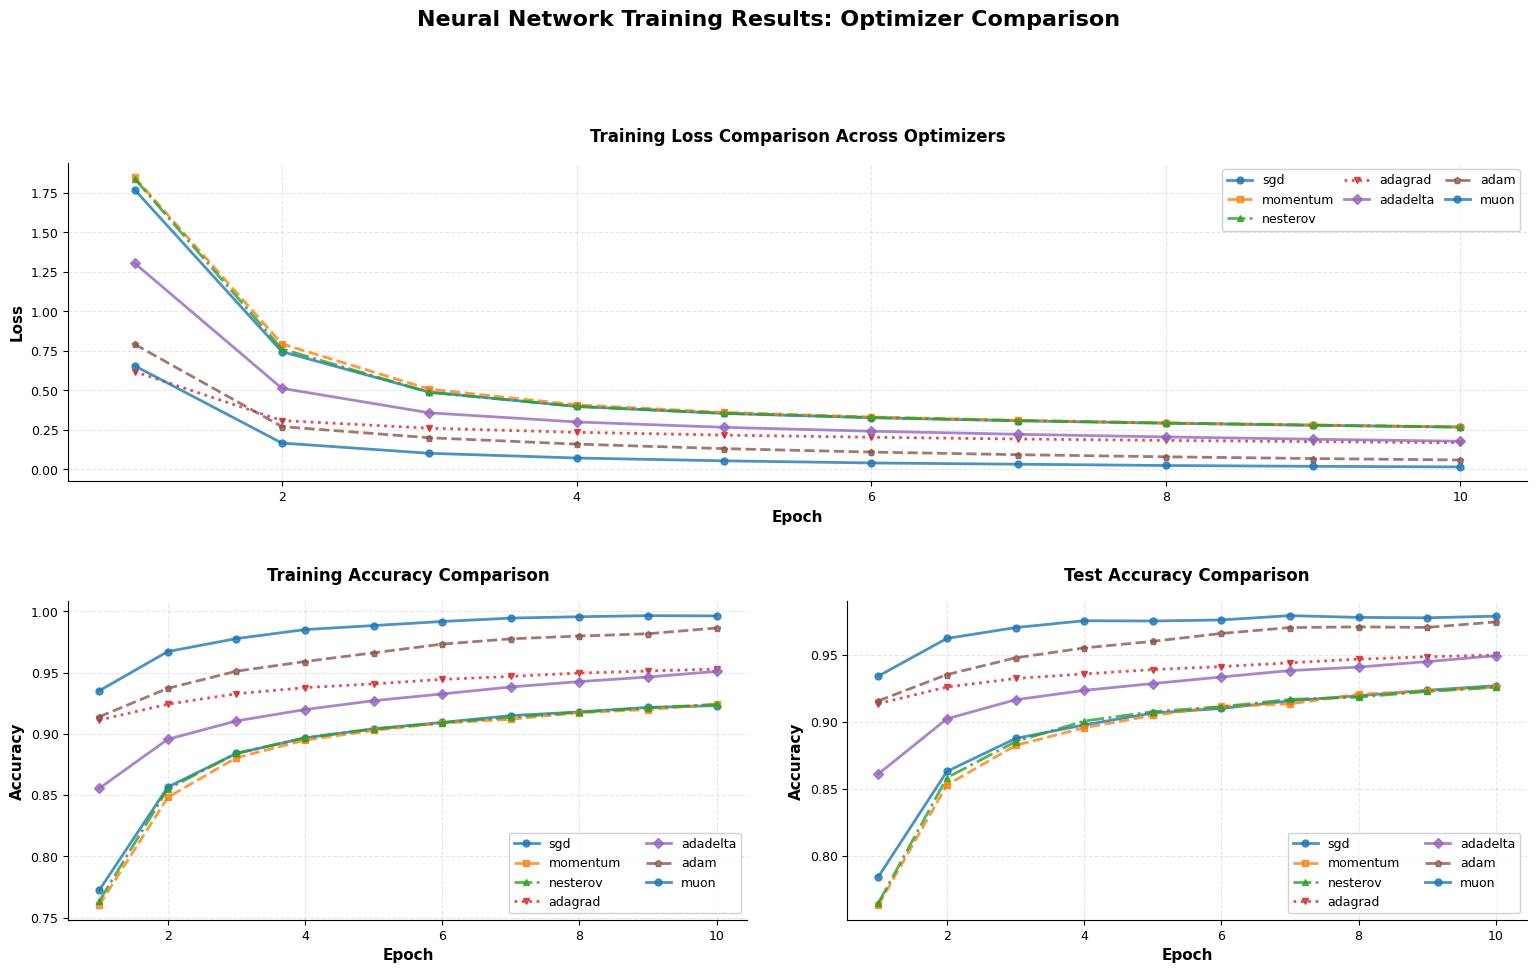

In [21]:
# =========================================
# 画对比损失曲线和精度曲线（美化版）
# =========================================
# 设置中文字体和样式
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 14

# 定义颜色和线型，使不同优化器更容易区分
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p']

# 创建更大的图形，使用2行2列布局（损失图占两列）
fig = plt.figure(figsize=(16, 10))

# 第一个子图：训练损失（占据上方两列）
ax1 = plt.subplot(2, 2, (1, 2))
for idx, (opt, loss_list) in enumerate(results_loss.items()):
    ax1.plot(range(1, len(loss_list)+1), loss_list,
            label=opt, color=colors[idx % len(colors)],
            linestyle=linestyles[idx % len(linestyles)],
            marker=markers[idx % len(markers)],
            markersize=5, linewidth=2, alpha=0.8)
ax1.set_title("Training Loss Comparison Across Optimizers", fontweight='bold', pad=15)
ax1.set_xlabel("Epoch", fontweight='bold')
ax1.set_ylabel("Loss", fontweight='bold')
ax1.legend(loc='upper right', framealpha=0.9, ncol=3, columnspacing=0.8)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 第二个子图：训练准确率
ax2 = plt.subplot(2, 2, 3)
for idx, (opt, acc_list) in enumerate(results_acc_train.items()):
    ax2.plot(range(1, len(acc_list)+1), acc_list,
            label=opt, color=colors[idx % len(colors)],
            linestyle=linestyles[idx % len(linestyles)],
            marker=markers[idx % len(markers)],
            markersize=5, linewidth=2, alpha=0.8)
ax2.set_title("Training Accuracy Comparison", fontweight='bold', pad=15)
ax2.set_xlabel("Epoch", fontweight='bold')
ax2.set_ylabel("Accuracy", fontweight='bold')
ax2.legend(loc='lower right', framealpha=0.9, ncol=2)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 第三个子图：测试准确率
ax3 = plt.subplot(2, 2, 4)
for idx, (opt, acc_list) in enumerate(results_acc_test.items()):
    ax3.plot(range(1, len(acc_list)+1), acc_list,
            label=opt, color=colors[idx % len(colors)],
            linestyle=linestyles[idx % len(linestyles)],
            marker=markers[idx % len(markers)],
            markersize=5, linewidth=2, alpha=0.8)
ax3.set_title("Test Accuracy Comparison", fontweight='bold', pad=15)
ax3.set_xlabel("Epoch", fontweight='bold')
ax3.set_ylabel("Accuracy", fontweight='bold')
ax3.legend(loc='lower right', framealpha=0.9, ncol=2)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# 添加总标题
fig.suptitle("Neural Network Training Results: Optimizer Comparison",
            fontsize=16, fontweight='bold', y=0.995)

# 调整布局，增加间距
plt.tight_layout(rect=[0, 0, 1, 0.98], pad=3.0)
plt.show()
